In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from random import choice
import src.cnc_simulator as cnc
import tests_updated.chp as chp

# Supporting functions

In [2]:
# generate random cliffords:
def generate_gate_sequence(n, beta):
    """Generate a random sequence of Clifford gates."""
    num_gates = int(beta * n * np.log2(n))
    gates = ['h', 's', 'cnot']
    sequence = []
    for _ in range(num_gates):
        gate = choice(gates)
        if gate == 'h' or gate == 's':  # Single qubit gates
            qubit = np.random.randint(0, n)
            sequence.append(f"{gate}_{qubit}")
        elif gate == 'cnot':  # Two-qubit gate
            control = np.random.randint(0, n)
            target = np.random.randint(0, n)
            while target == control:  # Ensure control != target
                target = np.random.randint(0, n)
            sequence.append(f"{gate}_{control}_{target}")
    return sequence


In [3]:
# apply random gate sequence with cnc sim:
def apply_sequence_of_clifford(simulator, sequence):
    """Apply a sequence of Clifford gates to the simulator."""
    for gate in sequence:
        if gate.startswith('h'):
            qubit = int(gate.split('_')[1])
            simulator.apply_hadamard(qubit)
        elif gate.startswith('s'):
            qubit = int(gate.split('_')[1])
            simulator.apply_phase(qubit)
        elif gate.startswith('cnot'):
            control, target = map(int, gate.split('_')[1:])
            simulator.apply_cnot(control, target)

In [4]:
# number of iterations
iterations = 1

# Varying $\beta$, fixed $m$

In [5]:
# Loop over beta and n ranges
beta_min = 0.6; beta_max = 1.21; delta = 0.2
beta_values = np.arange(beta_min, beta_max, delta)

# define qubit ranges:
n_min = 200; n_max = 1201; n_delta = 200
n_values = range(n_min, n_max, n_delta)  # n from 200 to 2000

m_doc_string = "n_over_2"
m_fig_string = "n/2"

results = []

for beta in beta_values:
    for n in n_values:
        print(f"Running simulation for beta={beta:.1f}, n={n}")

        # Generate Clifford gate sequence
        sequence = generate_gate_sequence(n, beta)

        # Initialize the CNC simulator
        m = int(n/2)
        simulator = cnc.CncSimulator(n, m)

        # Apply the gate sequence
        apply_sequence_of_clifford(simulator, sequence)

        # Prepare measurement bases
        zero_matrix = np.zeros((n, n), dtype=int)
        identity_matrix = np.eye(n, dtype=int)
        measurement_bases = np.hstack((identity_matrix,zero_matrix))

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, measurement_bases
"""

        # Define the statement to measure
        stmt_code = """
for base in range(measurement_bases.shape[0]):
    simulator.measure(measurement_bases[base, :])
"""

        # Time the execution
        repeat = iterations
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /(repeat*n)
        print(f"Average time per measurement ({repeat} iterations) for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds \n")

        # Store results
        results.append((beta, n, avg_time))

# Save to .npy file
np.save(f"./figures/cnc_measurement_n_{n_min}_{n_max}_{n_delta}_m_{m_doc_string}_beta_{beta_min}_{beta_max}_{delta}.npy", np.array(results))


Running simulation for beta=0.6, n=200
Average time per measurement (1 iterations) for beta=0.6, n=200: 0.000814 seconds 

Running simulation for beta=0.6, n=400
Average time per measurement (1 iterations) for beta=0.6, n=400: 0.002932 seconds 

Running simulation for beta=0.6, n=600
Average time per measurement (1 iterations) for beta=0.6, n=600: 0.003288 seconds 

Running simulation for beta=0.6, n=800
Average time per measurement (1 iterations) for beta=0.6, n=800: 0.008518 seconds 

Running simulation for beta=0.6, n=1000
Average time per measurement (1 iterations) for beta=0.6, n=1000: 0.012711 seconds 

Running simulation for beta=0.6, n=1200
Average time per measurement (1 iterations) for beta=0.6, n=1200: 0.017175 seconds 

Running simulation for beta=0.8, n=200
Average time per measurement (1 iterations) for beta=0.8, n=200: 0.001094 seconds 

Running simulation for beta=0.8, n=400
Average time per measurement (1 iterations) for beta=0.8, n=400: 0.003151 seconds 

Running simu

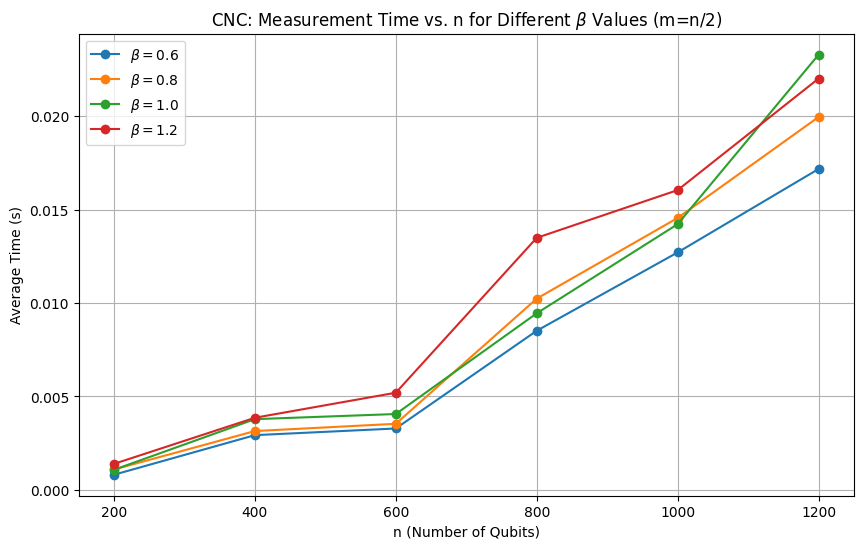

In [6]:
# Your numpy array
data = np.array(results)

# Extract unique beta values
betas = np.unique(data[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for beta in betas:
    subset = data[data[:, 0] == beta]  # Filter rows with the current beta
    n = subset[:, 1]
    avg_time = subset[:, 2]
    plt.plot(n, avg_time, marker='o', label=f"$\\beta={round(beta,1)}$")  # LaTeX syntax for beta

# Label the axes and add a legend
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title(f"CNC: Measurement Time vs. n for Different $\\beta$ Values (m={m_fig_string})")  # Use beta in title
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig(f"./figures/cnc_measurement_plot_n_{n_min}_{n_max}_{n_delta}_m_{m_doc_string}_beta_{beta_min}_{beta_max}_{delta}.png", format="png", dpi=300)

# Show the plot (optional)
plt.show()

# Fixed $\beta$, varying $m$

In [7]:
# Fix beta
beta = 1

# Number of even segments of n:
k = 4

# define qubit ranges:
n_min = 200; n_max = 2401; n_delta = 200
n_values = range(n_min, n_max, n_delta)  # n from 200 to 2000

results = []

for n in n_values:
    # Generate Clifford gate sequence
    sequence = generate_gate_sequence(n, beta)

    # define 
    m_values = [0,1]+[int(r*n/k) for r in range(1,k+1)]

    for m in m_values:

        print(f"Running simulation for m={m}, n={n}")

        # Initialize the CNC simulator
        simulator = cnc.CncSimulator(n, m)

        # Apply the gate sequence
        apply_sequence_of_clifford(simulator, sequence)

        # Prepare measurement bases
        zero_matrix = np.zeros((n, n), dtype=int)
        identity_matrix = np.eye(n, dtype=int)
        measurement_bases = np.hstack((identity_matrix,zero_matrix))

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, measurement_bases
"""

        # Define the statement to measure
        stmt_code = """
for base in range(measurement_bases.shape[0]):
    simulator.measure(measurement_bases[base, :])
    """

        # Time the execution
        repeat = iterations
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /(repeat*n)
        print(f"Average time per measurement ({repeat} iterations) for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds \n")

        # Store results
        results.append((beta, n, m, avg_time))

# Save to .npy file
np.save(f"./figures/cnc_measurement_n_{n_min}_{n_max}_{n_delta}_m_vary_{k}_beta_{beta}.npy", np.array(results))


Running simulation for m=0, n=200
Average time per measurement (1 iterations) for beta=1.0, n=200: 0.000776 seconds 

Running simulation for m=1, n=200
Average time per measurement (1 iterations) for beta=1.0, n=200: 0.000758 seconds 

Running simulation for m=50, n=200
Average time per measurement (1 iterations) for beta=1.0, n=200: 0.001115 seconds 

Running simulation for m=100, n=200
Average time per measurement (1 iterations) for beta=1.0, n=200: 0.001271 seconds 

Running simulation for m=150, n=200
Average time per measurement (1 iterations) for beta=1.0, n=200: 0.001305 seconds 

Running simulation for m=200, n=200
Average time per measurement (1 iterations) for beta=1.0, n=200: 0.001572 seconds 

Running simulation for m=0, n=400
Average time per measurement (1 iterations) for beta=1.0, n=400: 0.002415 seconds 

Running simulation for m=1, n=400
Average time per measurement (1 iterations) for beta=1.0, n=400: 0.002498 seconds 

Running simulation for m=100, n=400
Average time 

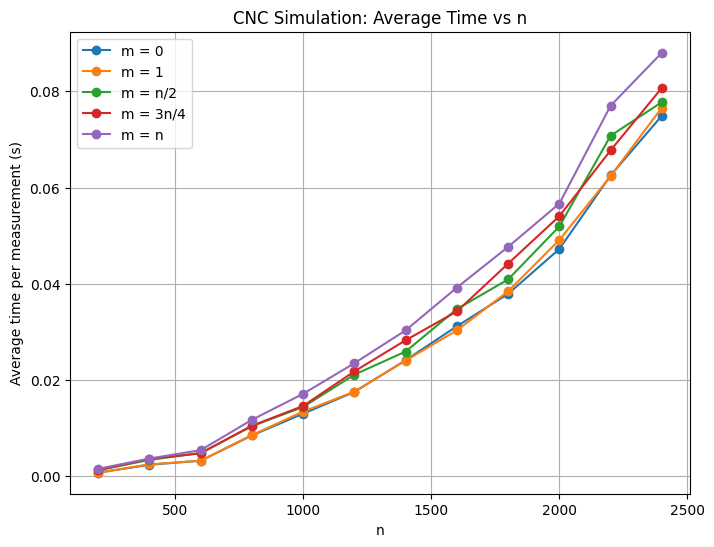

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load the simulation results from a .npy file (each entry is (beta, n, m, avg_time))
results = list(results)

# Assume k is defined (e.g., k = 4 or k = 5)
k = 4  # change as needed

# Create a dictionary with keys from 0 to k+1 (total of k+2 groups)
groups = {i: [] for i in range(0, k+2)}

# Grouping:
#   Group 0: m == 0
#   Group 1: m == 1
#   For groups 2 to k+1: m == int(r * n / k) for r=2,...,k+1.
for beta, n, m, avg_time in results:
    if m == 0:
        group = 0
    elif m == 1:
        group = 1
    else:
        # Check groups for r = 2 to k+1.
        for r in range(2, k+2):
            if m == int(r * n / k):
                group = r
                break
        else:
            # If no matching group is found, skip this entry.
            continue
    groups[group].append((n, avg_time))

# Sort each group's data by n.
for key in groups:
    groups[key] = np.array(sorted(groups[key], key=lambda x: x[0]))

# Define labels for each group.
# For example, when k = 4:
#   Group 0: "m = 0"
#   Group 1: "m = 1"
#   Group 2: "m = n/2" if int(2*n/4) equals n/2,
#   Group 3: "m = 3n/4",
#   Group 4: "m = n",
#   (Adjust labels as appropriate for your choice of k.)
labels = ["m = 0", "m = 1", "m = n/2", "m = 3n/4", "m = n", "Extra"]  # modify for different k

plt.figure(figsize=(8,6))
for i in range(k+2):
    if groups[i].size > 0:
        plt.plot(groups[i][:, 0], groups[i][:, 1], marker='o', label=labels[i])
plt.xlabel("n")
plt.ylabel("Average time per measurement (s)")
plt.title("CNC Simulation: Average Time vs n")
plt.legend()
plt.grid(True)
plt.show()


# Comparison with CHP

In [9]:
def apply_sequence_of_clifford_chp(simulator, sequence):
    """Apply a sequence of Clifford gates to the simulator."""
    for gate in sequence:
        if gate.startswith('h'):
            qubit = int(gate.split('_')[1])
            simulator.hadamard(qubit)
        elif gate.startswith('s'):
            qubit = int(gate.split('_')[1])
            simulator.phase(qubit)
        elif gate.startswith('cnot'):
            control, target = map(int, gate.split('_')[1:])
            simulator.cnot(control, target)

In [ ]:
# Loop over beta and n ranges
beta_min = 0.6; beta_max = 1.21; delta = 0.2
beta_values = np.arange(beta_min, beta_max, delta)

# define qubit ranges:
n_min = 200; n_max = 2401; n_delta = 200
n_values = range(n_min, n_max, n_delta)  # n from 200 to 2000

chp_results = []

for beta in beta_values:
    for n in n_values:
        print(f"Running simulation for beta={beta:.1f}, n={n}")

        # Generate Clifford gate sequence
        sequence = generate_gate_sequence(n, beta)

        simulator = chp.ChpSimulator(n)

        # Apply the gate sequence
        apply_sequence_of_clifford_chp(simulator, sequence)

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, n
"""

        # Define the statement to measure
        stmt_code = """
for qubit in range(n):
    simulator.measure(qubit)
"""

        # Time the execution
        repeat = iterations
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /(repeat*n)
        print(f"Average time per measurement ({repeat} iterations) for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds \n")

        # Store results
        chp_results.append((beta, n, avg_time))

# Save to .npy file
np.save(f"./figures/chp_measurement_n_{n_min}_{n_max}_{n_delta}_beta_{beta_min}_{beta_max}_{delta}.npy", np.array(chp_results))


Running simulation for beta=0.6, n=200
Average time per measurement (1 iterations) for beta=0.6, n=200: 0.000306 seconds 

Running simulation for beta=0.6, n=400
Average time per measurement (1 iterations) for beta=0.6, n=400: 0.001292 seconds 

Running simulation for beta=0.6, n=600
Average time per measurement (1 iterations) for beta=0.6, n=600: 0.001644 seconds 

Running simulation for beta=0.6, n=800
Average time per measurement (1 iterations) for beta=0.6, n=800: 0.003644 seconds 

Running simulation for beta=0.6, n=1000
Average time per measurement (1 iterations) for beta=0.6, n=1000: 0.009372 seconds 

Running simulation for beta=0.6, n=1200
Average time per measurement (1 iterations) for beta=0.6, n=1200: 0.009072 seconds 

Running simulation for beta=0.6, n=1400
Average time per measurement (1 iterations) for beta=0.6, n=1400: 0.013175 seconds 

Running simulation for beta=0.6, n=1600
Average time per measurement (1 iterations) for beta=0.6, n=1600: 0.022505 seconds 

Running 

## CNC simulator with $m=0$:

In [ ]:
# Loop over beta and n ranges
beta_min = 0.6; beta_max = 1.21; delta = 0.2
beta_values = np.arange(beta_min, beta_max, delta)

# define qubit ranges:
n_min = 200; n_max = 2401; n_delta = 200
n_values = range(n_min, n_max, n_delta)  # n from 200 to 2000

m = 0

cnc_results = []

for beta in beta_values:
    for n in n_values:
        print(f"Running simulation for beta={beta:.1f}, n={n}")

        # Generate Clifford gate sequence
        sequence = generate_gate_sequence(n, beta)

        # Initialize the CNC simulator
        simulator = cnc.CncSimulator(n, m)

        # Apply the gate sequence
        apply_sequence_of_clifford(simulator, sequence)

        # Prepare measurement bases
        zero_matrix = np.zeros((n, n), dtype=int)
        identity_matrix = np.eye(n, dtype=int)
        measurement_bases = np.hstack((identity_matrix,zero_matrix))

        # Define the setup code
        setup_code = f"""
import numpy as np
from __main__ import simulator, measurement_bases
"""

        # Define the statement to measure
        stmt_code = """
for base in range(measurement_bases.shape[0]):
    simulator.measure(measurement_bases[base, :])
"""

        # Time the execution
        repeat = iterations
        execution_time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=repeat)
        avg_time = execution_time /(repeat*n)
        print(f"Average time per measurement ({repeat} iterations) for beta={beta:.1f}, n={n}: {avg_time:.6f} seconds \n")

        # Store results
        cnc_results.append((beta, n, avg_time))

# Save to .npy file
np.save(f"./figures/cnc_measurement_n_{n_min}_{n_max}_{n_delta}_m_0_beta_{beta_min}_{beta_max}_{delta}.npy", np.array(cnc_results))

## CHP versus CNC Comparison

In [ ]:
# Load CHP results
#chp_data = np.load("./figures/chp_measurement_n_200_2001_100_beta_0.6_1.21_0.2.npy", allow_pickle=True)
chp_data = np.array(chp_results)

# Load CNC results
#cnc_data = np.load("./figures/cnc_measurement_n_200_2001_100_m_0_beta_0.6_1.21_0.2.npy", allow_pickle=True)
cnc_data = np.array(cnc_results)

# Extract unique beta values from each dataset
betas_chp = np.unique(chp_data[:, 0])
betas_cnc = np.unique(cnc_data[:, 0])

# Create a figure with two subplots: one for CHP and one for CNC.
plt.figure(figsize=(12, 6))

# Plot CHP model results
plt.subplot(1, 2, 1)
for beta in betas_chp:
    subset = chp_data[chp_data[:, 0] == beta]
    n_values = subset[:, 1]
    avg_time = subset[:, 2]
    plt.plot(n_values, avg_time, marker='o', label=f"$\\beta={round(beta,1)}$")
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title("CHP Model")
plt.legend()
plt.grid(True)

# Plot CNC model results
plt.subplot(1, 2, 2)
for beta in betas_cnc:
    subset = cnc_data[cnc_data[:, 0] == beta]
    n_values = subset[:, 1]
    avg_time = subset[:, 2]
    plt.plot(n_values, avg_time, marker='o', label=f"$\\beta={round(beta,1)}$")
plt.xlabel("n (Number of Qubits)")
plt.ylabel("Average Time (s)")
plt.title("CNC Model")
plt.legend()
plt.grid(True)

plt.suptitle("CHP vs. CNC: Measurement Times vs. n for Different $\\beta$ Values")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./figures/measurement_times_comparison.png", dpi=300)
plt.show()
